In [98]:
%load_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import glob
import sys
import yaml

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tempest import casestudy
from tempest import grid
from tempest import joint_distrib
from tempest import handler

from scipy.optimize import curve_fit

settings_path = 'settings/tropics.yaml'

In [3]:
# Instantiate CaseStudy by passing the settings. 
# Should also create appropriate directories
hdlr = handler.Handler(settings_path)
cs = casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False)
gr = grid.Grid(cs, fast = True, overwrite= False, verbose_steps = False, verbose = False)
# jd = joint_distrib.JointDistribution(gr)

if __name__ == '__main__':
    # print("Loaded Configuration:")
    # for key, value in settings.items():
    #     print(f"{key}: {value}")
    
    #gr.compute_funcs_for_var_id()
    pass


Data loaded from /homedata/mcarenso/tempest/DYAMOND_SAM_Tropics/var_id_days_i_t.json
Found grid attributes file , so loading /homedata/mcarenso/tempest/DYAMOND_SAM_Tropics/grid_attributes.pkl instead of computing


# Retrieve storms object


In [6]:
jd = joint_distrib.JointDistribution(gr, nd=5, storm_tracking=True, verbose=True)

Distribs loaded
Overwrite set to false so loading basics attributes from .npy
Loading storms...
/data/fiolleau/DYAMOND/TOOCAN/TOOCAN_v2.07/GLOBAL/2016/FileTracking/TOOCAN-GLOBAL-20160901-20160910.dat.gz
/data/fiolleau/DYAMOND/TOOCAN/TOOCAN_v2.07/GLOBAL/2016/FileTracking/TOOCAN-GLOBAL-20160801-20160831.dat.gz
Retrieve labels in jdist


# Check density and storm_tracking

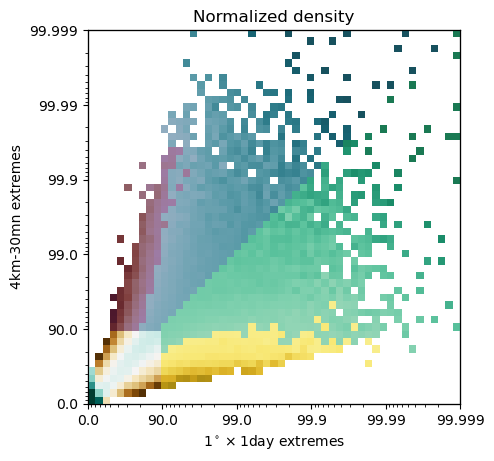

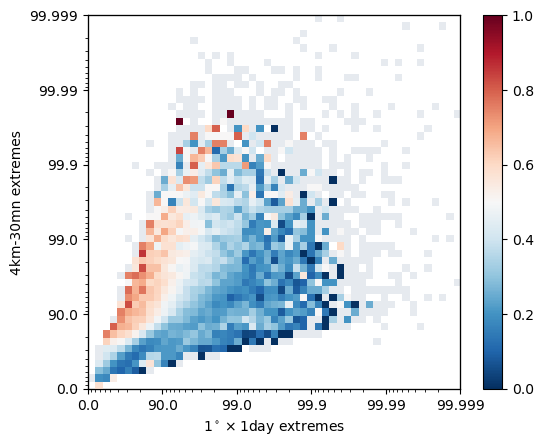

In [7]:
%matplotlib inline
jd.plot(branch=False)

data, noise = jd.get_mcs_bin_fraction()
jd.plot_data(data, noise, branch=False)

# Dev plane fit to extreme rains

True


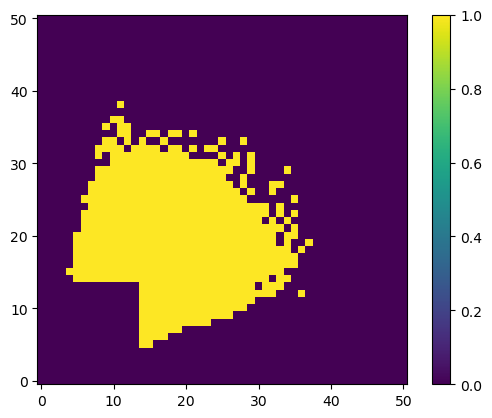

In [57]:
import numpy as np
from sklearn.linear_model import LinearRegression
from numpy.ma import masked_array

# Example 2D array with np.nan values
array_2d, noise = jd.get_mcs_bin_fraction()
array_2d = 100*array_2d
mask_jdist_below_treshold = np.outer(jd.dist1.ranks < 95, jd.dist2.ranks < 95)
mask_treshold_for_plane_fit = np.logical_and(~mask_jdist_below_treshold, ~np.isnan(array_2d))
plt.imshow(mask_treshold_for_plane_fit, origin = 'lower')
plt.colorbar()
print(True==1)
plt.show()

# Create masked array for y
# y = masked_array(array_2d.flatten(), mask=mask_treshold_for_plane_fit.flatten())
y = array_2d[mask_treshold_for_plane_fit]

xx, yy = np.meshgrid(np.arange(array_2d.shape[0]), np.arange(array_2d.shape[1]))

# xx = masked_array(xx.flatten(), mask=mask_treshold_for_plane_fit.flatten())
# yy = masked_array(yy.flatten(), mask=mask_treshold_for_plane_fit.flatten())

X = np.column_stack((xx[mask_treshold_for_plane_fit], yy[mask_treshold_for_plane_fit]))
# X = masked_array(X, mask=mask_treshold_for_plane_fit.flatten())

model = LinearRegression().fit(X, y)

# Equation is a*bin_i+b*bin_j+c = y
model_plane = model.predict(X)


In [58]:
y_pred = np.full_like(array_2d, np.nan)
y_pred[mask_treshold_for_plane_fit] = model_plane

/scratchx/mcarenso/ipykernel_1227037/2234860476.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  cx = plt.figure(figsize=(12,6)).gca(projection='3d')


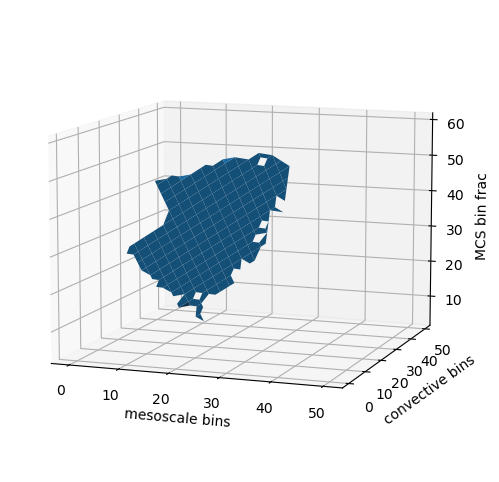

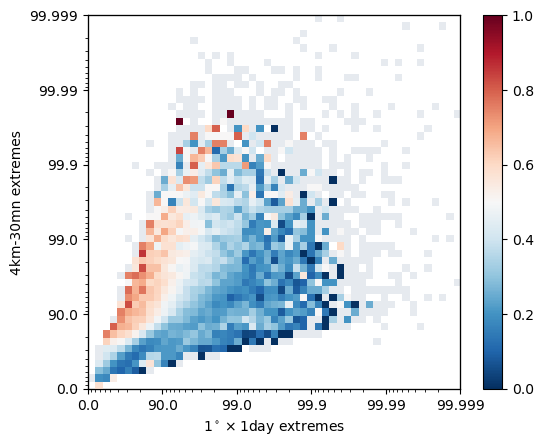

In [82]:
%matplotlib inline
cx = plt.figure(figsize=(12,6)).gca(projection='3d')

# cx.scatter(xx[mask_treshold_for_plane_fit], yy[mask_treshold_for_plane_fit], y, color = 'green')
cx.plot_surface(xx, yy, y_pred, alpha = 1)
cx.set(xlabel = 'mesoscale bins', ylabel='convective bins', zlabel = 'MCS bin frac')
cx.view_init(elev=10, azim=290)

data, noise = jd.get_mcs_bin_fraction()
jd.plot_data(data, noise, branch=False)

In [52]:
model.intercept_
model.coef_

array([ 0.00922584, -0.01337559])

# Average data over ranks from one of the distribs

In [92]:
from tempest.storm_analysis import set_storm_growth_rate

file = os.path.join(jd.jd_path, 'storms_growth_rates.npy')
storms_growth_rates = np.load(file)
for storm, growth_rate in zip(jd.storms, storms_growth_rates):
    setattr(storm, 'growth_rate', growth_rate)

In [95]:
# should be saved
mean_growth_rate = jd.storm_attributes_on_jdist(['growth_rate'], ['mean'])[0][0,0,:,:]
max_growth_rate = jd.storm_attributes_on_jdist(['growth_rate'], ['max'])[0][0,0,:,:]


0123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495001234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950

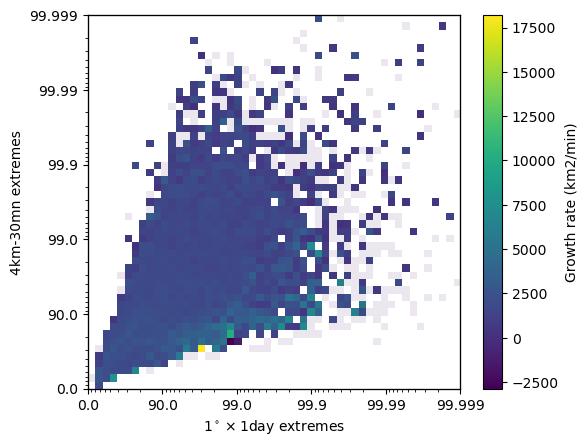

In [99]:
data = mean_growth_rate
jd.plot_data(data, noise, cmap = plt.cm.viridis, branch=False, label = 'Growth rate (km2/min)')

[           nan            nan            nan            nan
            nan            nan -1339.26770354  1505.66128315
  3629.64153914  4441.64471513  2761.00080949  2246.11056402
  3037.64522775  1720.92862727  2045.75732933  1786.84522949
  2108.68071629  1824.2632955   1682.41778194  2393.16730183
  1306.86497757  1905.59324913  1762.2574188   1648.73864316
  1481.29690636  1342.31301552  1608.56222134  1317.69670552
  1612.39728997  1457.26746676   998.06977618  1320.80382024
  1340.5565529   1586.98759065  1497.92111979  1522.85024931
  2699.38048454  1284.1750571   1540.98646648  2187.69555576
  2002.58533123  1376.13983571  1963.08203165  1374.69145782
            nan            nan            nan            nan
            nan            nan            nan]


/scratchx/mcarenso/ipykernel_1227037/2146964683.py:4: RuntimeWarning: Mean of empty slice
  data_mean_subset = np.nanmean(data[np.logical_and(rank_low<=jd.dist1.ranks, jd.dist1.ranks<=rank_high), :], axis = axis)


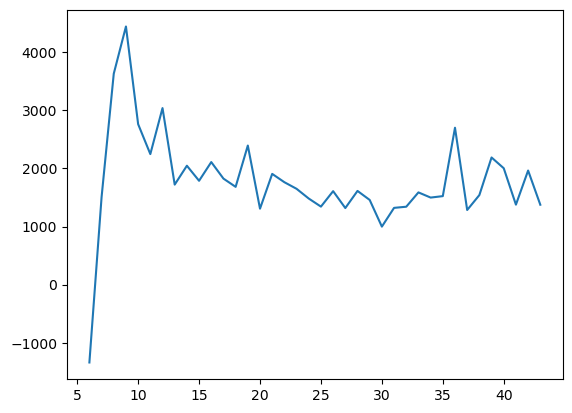

In [115]:
rank_low, rank_high = 99, 99.9
axis = 0
if axis == 0 : 
    data_mean_subset = np.nanmean(data[np.logical_and(rank_low<=jd.dist1.ranks, jd.dist1.ranks<=rank_high), :], axis = axis)
elif axis == 1 : 
    data_mean_subset = np.nanmean(data[:, np.logical_and(rank_low<=jd.dist2.ranks, jd.dist2.ranks<=rank_high)], axis = axis)

print(data_mean_subset)
plt.plot(data_mean_subset)